In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
df_as = pd.read_csv('~/first_project/assessments.csv')
df_as.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [3]:
df_co = pd.read_csv('~/first_project/courses.csv')
df_co.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [4]:
df_sa = pd.read_csv('~/first_project/studentAssessment.csv')
df_sa.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [5]:
df_sr = pd.read_csv('~/first_project/studentRegistration.csv')
df_sr.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


**Задание 1.
Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)**

В моем понимании, успешная сдача курса - это комбинация условий, при которых учитывается сдача предмета и:

1) тип тестирования - экзамен по курсу (assessment_type = Exam)

2) оценка тестирования - более или равно 40 баллов (score >= 40.0)

Объединяем два датафрейма, выделяем только те записи, в которых тип тестирования является экзаменом, результат выше или равен 40 баллов, выбираем только тех студентов, которые прошли только один курс, после чего подсчитываем число уникальных id_student, т.к. один студент теоретически мог пройти один тест несколько раз на оценку выше 40 баллов.

Результат записан в переменной students_count_success и равен 3802.

In [6]:
students_count_success = df_as.merge(df_sa, how = 'inner')\
                                .query('assessment_type == "Exam" and score >= 40.0')\
                                .groupby('id_student', as_index = False)\
                                .agg({'id_assessment':'count'})\
                                .query('id_assessment == 1')\
                                .id_student.nunique()
students_count_success

3802

**Задание 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью**

Завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен.

Для этого необходимо объединить два датафрейма, посчитать завершаемость (добавляем столбец finished). Сортируем по убыванию, берем наибольшее и наименьшее количество студентов согласно динамике завершаемости, а именно получаем экзамены **25361** и **25340** соответственно. 

Далее смотрим, в рамках каких курсов проводились эти экзамены. Они проводились в рамках предмета **DDD**.

In [7]:
df_score = df_as.merge(df_sa, how = 'inner')\
             .query('score >= 40.0 and assessment_type == "Exam"')\
             .groupby('id_assessment', as_index = False)\
             .agg({'id_student':'count'})
df_score

,id_assessment,id_student
0,24290,664
1,24299,1019
2,25340,504
3,25354,878
4,25361,485
5,25368,842


In [8]:
df_non_score = df_as.merge(df_sa, how = 'inner')\
               .query('assessment_type == "Exam"')\
               .groupby('id_assessment', as_index = False)\
               .agg({'id_student':'count'})
df_non_score

,id_assessment,id_student
0,24290,747
1,24299,1168
2,25340,602
3,25354,968
4,25361,524
5,25368,950


In [9]:
df_as_sa_finished = df_as.merge(df_sa, how = 'inner')\
                  .query('assessment_type == "Exam"')\
                  .groupby(['code_module', 'id_assessment'], as_index = False)\
                  .agg({'id_student':'count'})
df_as_sa_finished

,code_module,id_assessment,id_student
0,CCC,24290,747
1,CCC,24299,1168
2,DDD,25340,602
3,DDD,25354,968
4,DDD,25361,524
5,DDD,25368,950


In [10]:
df_as_sa_finished['finished'] = (df_score.id_student/df_non_score.id_student).round(2)
df_as_sa_finished.sort_values('finished', ascending = False)

,code_module,id_assessment,id_student,finished
4,DDD,25361,524,0.93
3,DDD,25354,968,0.91
0,CCC,24290,747,0.89
5,DDD,25368,950,0.89
1,CCC,24299,1168,0.87
2,DDD,25340,602,0.84


**Задание 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).**

Сначала рассмотрим датафрейм df_as_sa. Мёрджим его с df_sr, а затем с df_co. В полученном датафрейме добавляем столбец duration, который содержит в себе информацию, через сколько дней после начала курса студент сдал экзамен (так как в условии задания написано именно **экзамен**, а не любой другой тип тестирования). Учитываем, что успешной считается сдача с score больше или равно 40 баллов. Высчитываем среднее количество дней, группируя датафрейм по коду предмета и округляя полученные значения до целых.

Предметы, прохождение которых завершается именно **экзаменом** - ССС и DDD. Средний срок сдачи экзаменов сохранен в df_dur_mean, а средний срок завершения курса сохранен в df_dur_mean_module.

In [11]:
df_dur = df_as.merge(df_sa, how = 'inner')\
              .query('assessment_type == "Exam" and score >= 40.0')\
              .merge(df_sr, how = 'left')\
              .merge(df_co, how = 'left')
df_dur.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length
0,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0,-22.0,NaN,241
1,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0,-22.0,NaN,241
2,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0,-281.0,NaN,241
3,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0,-28.0,NaN,241
4,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0,-46.0,NaN,241


In [12]:
df_dur['duration'] = df_dur.module_presentation_length - df_dur.date_submitted
df_dur.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,date_registration,date_unregistration,module_presentation_length,duration
0,CCC,2014B,24290,Exam,NaN,100.0,559706,234,0,78.0,-22.0,NaN,241,7
1,CCC,2014B,24290,Exam,NaN,100.0,559770,230,0,54.0,-22.0,NaN,241,11
2,CCC,2014B,24290,Exam,NaN,100.0,560114,230,0,64.0,-281.0,NaN,241,11
3,CCC,2014B,24290,Exam,NaN,100.0,560311,234,0,100.0,-28.0,NaN,241,7
4,CCC,2014B,24290,Exam,NaN,100.0,560494,230,0,92.0,-46.0,NaN,241,11


In [13]:
df_dur_mean = df_dur.groupby(['code_module', 'id_assessment'], as_index = False)\
                    .agg({'duration':'mean'})\
                    .round(2)
df_dur_mean

,code_module,id_assessment,duration
0,CCC,24290,9.42
1,CCC,24299,24.60
2,DDD,25340,9.84
3,DDD,25354,21.49
4,DDD,25361,6.06
5,DDD,25368,19.20


In [14]:
df_dur_mean_module = df_dur_mean.groupby('code_module', as_index = False)\
                                .agg({'duration':'mean'})\
                                .round(2)
df_dur_mean_module

,code_module,duration
0,CCC,17.01
1,DDD,14.15


**Задание 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).**

Для выполнения данного задания берем датафрейм df_sr, считаем для каждого предмета количество зарегистрированных студентов, сортируем по убыванию. Наиболее популярными предметами оказались предметы с code_module **BBB, FFF, DDD**.

Далее нам необходимо высчитать отток студентов. Для этого нам необходимо объединить датафреймы df_sr и df_co, чтобы посмотреть в совокупности, какие студенты отменили регистрацию с предмета в течение семестра (не учитываем студентов, которые завершили курс). Так как некоторые студенты зарегистрировались на предмет раньше начала семестра, делаем расчеты среди студентов, где длительность обучения на предмете меньше, чем длительность семестра с этим предметом. И полученные предметы с самым большим оттоком - **BBB, FFF, DDD**.

In [15]:
df_sr.groupby('code_module', as_index = False)\
     .agg({'id_student':'count'})\
     .sort_values('id_student', ascending = False)

,code_module,id_student
1,BBB,7909
5,FFF,7762
3,DDD,6272
2,CCC,4434
4,EEE,2934
6,GGG,2534
0,AAA,748


In [16]:
df_sr.merge(df_co, how = 'inner')\
     .fillna(df_co.module_presentation_length)\
     .query('date_registration + module_presentation_length > date_unregistration')\
     .groupby('code_module', as_index = False)\
     .agg({'id_student':'count'})\
     .sort_values('id_student', ascending = False)

,code_module,id_student
1,BBB,2195
5,FFF,2172
3,DDD,1948
2,CCC,1704
4,EEE,674
6,GGG,271
0,AAA,101


**Задание 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.**

Объединим датафреймы с информацией о семестре, количеством студентов, сдавших экзамен, и средней длительностью прохождения курса. Высчитаем завершаемость, отсортируем полученный датафрейм сначала по завершаемости, затем по средней длительностию

Семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов в период с начала 2013 по конец 2014 - **2014J**.

In [17]:
df_as_sa = df_as.merge(df_sa, how = 'inner')\
                .merge(df_co, how = 'inner')\
                .query('assessment_type == "Exam"')\
                .groupby(['code_module', 'code_presentation','id_assessment'], as_index = False)\
                .agg({'id_student':'count'})\
                .sort_values('id_student', ascending = False)
df_as_sa

,code_module,code_presentation,id_assessment,id_student
1,CCC,2014J,24299,1168
3,DDD,2013J,25354,968
5,DDD,2014J,25368,950
0,CCC,2014B,24290,747
2,DDD,2013B,25340,602
4,DDD,2014B,25361,524


In [18]:
df_as_sa_score = df_as.merge(df_sa, how = 'inner')\
                  .query('score >= 40.0 and weight == 100.0')\
                  .groupby(['code_module', 'code_presentation', 'id_assessment'], as_index = False)\
                  .agg({'id_student':'count'})\
                  .sort_values('id_student', ascending=False)
df_as_sa_score

,code_module,code_presentation,id_assessment,id_student
1,CCC,2014J,24299,1019
3,DDD,2013J,25354,878
5,DDD,2014J,25368,842
0,CCC,2014B,24290,664
2,DDD,2013B,25340,504
4,DDD,2014B,25361,485


In [19]:
df_as_sa['finished'] = df_as_sa_score.id_student/df_as_sa.id_student
df_as_sa.head()

,code_module,code_presentation,id_assessment,id_student,finished
1,CCC,2014J,24299,1168,0.872432
3,DDD,2013J,25354,968,0.907025
5,DDD,2014J,25368,950,0.886316
0,CCC,2014B,24290,747,0.888889
2,DDD,2013B,25340,602,0.837209


In [20]:
df_as_sa.merge(df_dur_mean, how = 'inner')\
        .sort_values('finished', ascending = True)\
        .sort_values('duration', ascending = False)\
        .head(1)\
        .code_presentation

0    2014J
Name: code_presentation, dtype: object

**Задание 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.**

Ранее полученные датафреймы адаптируем в группировке по студентам. В случаях, где столбец finished хранит значение NaN, мы приходим к выводу, что вероятнее всего студент так и не смог перейти порог в 40 баллов, либо не уложился в сроки.

На основании полученного датафрейма организуем кластеры студентов. Кластеры формируются по показателям R и F, при это меньшие значения R лучше, чем большие, а для F большие значения лучше, чем меньшие. Кластеры выглядят следующим образом:

'F student' - R = 5, F = 1 - студенты, осваивающие программу хуже всех, требуют больше попыток, чем остальные.

'D student' - R = 4-5, F = 2-3 (разделяем на подкластеры D и D+ - чем меньше модуль разницы, тем ниже кластер) - студенты-ударники, сдающие часть экзаменов с 4+ попытки.

'B student' - R = 2-3, F = 4-5 (разделяем на подкластеры В и В+ по тому же принципу) - студены-хорошисты, сдающие большинство экзаменов за 1-3 попытки.

'A student' - R = 1, F = 5 (разделяем на подкластеры А и А+ по тому же принципу) - студенты-отличники, сдающие практически все экзамены с первого раза.

Нас интересуют студенты с грейдом от А до D+, так как у них наиболее высокие показатели - подсвечиваем их на графике. 

По результатам анализа распределение по кластерам имеет следующий вид: 0.02% A+ student, 0.09% A student, 0.06% B+ student, 17.01% B student, 22.75% D+ student; 60.07% находятся в 'красной зоне'.

In [21]:
rfm = df_sa.merge(df_as, how = 'left')\
           .query('assessment_type == "Exam"')\
           .groupby('id_student', as_index = False)\
           .agg({'score':'mean'}).round(2)
rfm.head()

,id_student,score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0


In [22]:
df_all = df_sa.merge(df_as, how = 'left')\
              .query('assessment_type == "Exam"')\
              .groupby('id_student', as_index = False)\
              .agg({'id_assessment':'count'})
df_all.head()

,id_student,id_assessment
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1


In [23]:
df_score = df_sa.merge(df_as, how = 'left')\
             .query('assessment_type == "Exam"')\
             .groupby(['id_student', 'score'], as_index = False)\
             .agg({'id_assessment':'count'}).query('score >= 40.0')
df_score.head()

,id_student,score,id_assessment
0,23698,80.0,1
1,24213,58.0,1
2,27116,96.0,1
3,28046,40.0,1
4,28787,44.0,1


In [24]:
rfm['finished'] = (df_score.id_assessment/df_all.id_assessment).round(2)
rfm['finished'] = rfm['finished'].fillna(0)
rfm.head()

,id_student,score,finished
0,23698,80.0,1.0
1,24213,58.0,1.0
2,27116,96.0,1.0
3,28046,40.0,1.0
4,28787,44.0,1.0


In [25]:
df_as_sa = df_as.merge(df_sa, how='right')
df_as_sa.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score
0,AAA,2013J,1752,TMA,19.0,10.0,11391,18,0,78.0
1,AAA,2013J,1752,TMA,19.0,10.0,28400,22,0,70.0
2,AAA,2013J,1752,TMA,19.0,10.0,31604,17,0,72.0
3,AAA,2013J,1752,TMA,19.0,10.0,32885,26,0,69.0
4,AAA,2013J,1752,TMA,19.0,10.0,38053,19,0,79.0


In [26]:
rfm['duration'] = df_as_sa.date_submitted

In [27]:
rfm.head()

,id_student,score,finished,duration
0,23698,80.0,1.0,18
1,24213,58.0,1.0,22
2,27116,96.0,1.0,17
3,28046,40.0,1.0,26
4,28787,44.0,1.0,19


In [28]:
rfm = rfm.rename(columns={'duration':'R', 'finished':'F', 'score':'M'})
rfm.head()

,id_student,M,F,R
0,23698,80.0,1.0,18
1,24213,58.0,1.0,22
2,27116,96.0,1.0,17
3,28046,40.0,1.0,26
4,28787,44.0,1.0,19


In [29]:
quintiles = rfm[['R', 'F', 'M']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'R': {0.2: 18.0, 0.4: 22.0, 0.6: 64.0, 0.8: 166.0},
 'F': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'M': {0.2: 46.200000000000045, 0.4: 60.0, 0.6: 72.0, 0.8: 84.0}}

In [30]:
def r_score(x):
    if x <= quintiles['R'][.2]:
        return 5
    elif x <= quintiles['R'][.4]:
        return 4
    elif x <= quintiles['R'][.6]:
        return 3
    elif x <= quintiles['R'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [31]:
rfm['R'] = rfm['R'].apply(lambda x: r_score(x))
rfm['F'] = rfm['F'].apply(lambda x: fm_score(x, 'F'))
rfm['M'] = rfm['M'].apply(lambda x: fm_score(x, 'M'))

In [32]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,id_student,M,F,R,RFM Score
0,23698,4,1,5,514
1,24213,2,1,4,412
2,27116,5,1,5,515
3,28046,1,1,3,311
4,28787,1,1,4,411


In [33]:
segt_map = {
    r'51': 'F student',
    r'5[2-3]': 'D student',
    r'54': 'D+ student',
    r'55': 'B student',
    r'4[1-2]': 'D student',
    r'43': 'D+ student',
    r'4[4-5]': 'B student',
    r'31': 'D student',
    r'32': 'D+ student',
    r'3[3-4]': 'B student',
    r'35': 'B+ student',
    r'21': 'D+ student',
    r'2[2-3]': 'B student',
    r'24': 'B+ student',
    r'25': 'A student',
    r'1[1-2]': 'B student',
    r'13': 'B+ student',
    r'14': 'A student',
    r'15': 'A+ student'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,id_student,M,F,R,RFM Score,Segment
0,23698,4,1,5,514,F student
1,24213,2,1,4,412,D student
2,27116,5,1,5,515,F student
3,28046,1,1,3,311,D student
4,28787,1,1,4,411,D student


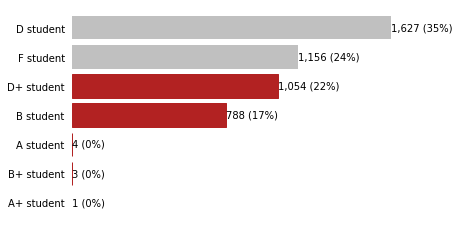

In [34]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['A student', 'A- student', 'B+ student', 'B student', 'B- student', 'D+ student']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()